In [1]:
# use n,x,5000
#use 1dcnn
#two

In [2]:
!pip install -U accelerate

   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 336.4/336.4 kB 8.0 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.34.2
    Uninstalling accelerate-0.34.2:
      Successfully uninstalled accelerate-0.34.2


In [3]:
!pip install git+https://github.com/lyhue1991/torchkeras

  Cloning https://github.com/lyhue1991/torchkeras to /tmp/pip-req-build-tgebm5r6
  Running command git clone --filter=blob:none --quiet https://github.com/lyhue1991/torchkeras /tmp/pip-req-build-tgebm5r6
  Resolved https://github.com/lyhue1991/torchkeras to commit e76056051ae529662ecbf48b53da5be12094567b
  Preparing metadata (setup.py) ... done
  Created wheel for torchkeras: filename=torchkeras-4.0.3-py3-none-any.whl size=45309457 sha256=5a20a24c2972a966ccc8555bae9eca98c68564d6479d750114ea97792a5958c4
  Stored in directory: /tmp/pip-ephem-wheel-cache-zvjqbnz1/wheels/57/53/ef/298ba6f59ff9f8b295a17a3f226848e6062b17e19aab3dc7d2
Successfully built torchkeras


In [4]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
from pprint import pprint
from matplotlib import pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from scipy.signal import savgol_filter #Êª§Ê≥¢
from sklearn.preprocessing import MinMaxScaler  
from torch.utils.data import Dataset,DataLoader
import torchkeras 

In [5]:
import torch
import torch.nn as nn
import math
class DepthwiseSeparableConv1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super(DepthwiseSeparableConv1D, self).__init__()
        self.depthwise = nn.Conv1d(in_channels, in_channels, kernel_size=kernel_size, 
                                   groups=in_channels, padding=kernel_size//2)
        self.pointwise = nn.Conv1d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x
class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads, num_layers, num_classes,feedforward, max_len=5000,dropout=0):
        super(TimeSeriesTransformer, self).__init__()
       #Ê∑±Â∫¶ÂèØÂàÜÁ¶ªÂç∑ÁßØÈôçÁª¥
        self.conv1=DepthwiseSeparableConv1D(in_channels=1,out_channels=32,kernel_size = 11)
        self.relu=nn.ReLU()
        self.maxpool= nn.MaxPool1d(2)#Á≠â‰ª∑‰∫énn.MaxPool1d(kernel_size=2, stride=2)
        self.conv2=DepthwiseSeparableConv1D(in_channels=32,out_channels=64,kernel_size = 21)
        self.conv3=DepthwiseSeparableConv1D(in_channels=64,out_channels=128,kernel_size = 41)
         # Á∫øÊÄßÊäïÂΩ±Â±ÇÔºåÂ∞ÜËæìÂÖ•Êï∞ÊçÆ5000Êò†Â∞ÑÂà∞ embed_dim Áª¥Â∫¶
        self.embedding = nn.Linear(input_dim, embed_dim)
        
        # ‰ΩçÁΩÆÁºñÁ†Å
        self.pos_encoder = PositionalEncoding(embed_dim, max_len)
        
        # Transformer ÁºñÁ†ÅÂô®Â±Ç
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads,
                                                   dim_feedforward=feedforward, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        
        # ÂÖ®Â±ÄÊ±†ÂåñÔºàÊàñËÄÖÂèØ‰ª•ÈÄâÁî® [CLS] token Ë°®Á§∫Ôºâ
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        
        # ÊúÄÁªàÂàÜÁ±ªÂ±Ç
        self.fc = nn.Linear(embed_dim, num_classes)
    
    def forward(self, x):
#         x = x.permute(0, 2, 1)
        #ËΩ¨ÁΩÆÂç∑ÁßØforward
        x=self.conv1(x)
        x=self.relu(x)
        x=self.maxpool(x)
        
        x=self.conv2(x)
        x=self.relu(x)
        x=self.maxpool(x)
        
        x=self.conv3(x)
        x=self.relu(x)
        x=self.maxpool(x)
        # print(x.shape)
        # ËæìÂÖ• x ÁöÑÂΩ¢Áä∂Ôºö[batch_size, seq_len, input_dim]
        x = self.embedding(x)  # ÂΩ¢Áä∂Âèò‰∏∫Ôºö[batch_size, seq_len, embed_dim]
        x = self.pos_encoder(x)  # Ê∑ªÂä†‰ΩçÁΩÆÁºñÁ†Å
        x = x.permute(1, 0, 2)  # Transformer ÊúüÊúõÁöÑËæìÂÖ•ÂΩ¢Áä∂Ôºö[seq_len, batch_size, embed_dim]
        
        # ÈÄöËøá Transformer ÁºñÁ†ÅÂô®
        x = self.transformer_encoder(x)  # ËæìÂá∫ÂΩ¢Áä∂Ôºö[seq_len, batch_size, embed_dim]
        x = x.permute(1, 2, 0)  # Ë∞ÉÊï¥ÂΩ¢Áä∂‰∏∫Ôºö[batch_size, embed_dim, seq_len]
        
        # ÂÖ®Â±ÄÂπ≥ÂùáÊ±†Âåñ
        x = self.global_avg_pool(x).squeeze(-1)  # ÂΩ¢Áä∂Âèò‰∏∫Ôºö[batch_size, embed_dim]
        
        # ÂÖ®ËøûÊé•ÂàÜÁ±ªÂ±Ç
        x = self.fc(x)  # ËæìÂá∫ÂΩ¢Áä∂Ôºö[batch_size, num_classes]
        return x

class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, embed_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * (-math.log(10000.0) / embed_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # [1, max_len, embed_dim]
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]  # Âä†‰∏ä‰ΩçÁΩÆÁºñÁ†Å



In [6]:
from argparse import Namespace
from torch.optim import lr_scheduler
config = Namespace(
    project_name = "two-transformer",
    file_path = "alldata.csv",
    batch_size = 128,
    dropout_p = 0.3,
    lr = 0.0002,
    optim_type = 'Adam',
    epochs = 200,
    ckpt_path = 'checkpoint',
    num_workers=0,
    name='two-1ddstn',
    input_dim = 625,  # ËΩ¨ÁΩÆÂç∑ÁßØÁöÑËæìÂá∫Áª¥Â∫¶
    feedforward=128,
    embed_dim = 64,  # ÂµåÂÖ•Áª¥Â∫¶
    num_heads = 4,  # Ê≥®ÊÑèÂäõÂ§¥Êï∞
    num_layers = 2,  # Transformer ÁºñÁ†ÅÂô®ÁöÑÂ±ÇÊï∞
    num_classes = 1,  # ÂàÜÁ±ªÁ±ªÂà´Êï∞
    max_len = 5000  # ËæìÂÖ•ÁöÑÊúÄÂ§ßÂ∫èÂàóÈïøÂ∫¶
)

torch.manual_seed(17) #cpu
torch.cuda.manual_seed(17) #gpu
np.random.seed(17) #numpy

In [7]:
from torchkeras import summary
# a=torch.randn([2,1,5000])
net = TimeSeriesTransformer(config.input_dim, config.embed_dim, config.num_heads, 
                            config.num_layers, config.num_classes,config.feedforward, config.max_len,config.dropout_p)
# summary(net,input_data=a)

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [8]:
class MyDataset(Dataset):
    def __init__(self,filepath):
        self.alldata=pd.read_csv(filepath,header=None)
        self.len=self.alldata.shape[0]
        self.alldata=np.array(self.alldata,dtype='float32')
        self.xdata=torch.from_numpy(self.alldata[:,0:-2])
        self.ydata=torch.from_numpy(self.alldata[:,[-2]])##‰∫åÂàÜÁ±ª
    def __getitem__(self,index):
        xx=self.xdata[index]
        lb=savgol_filter(xx, window_length=7, polyorder=2)#Savitzky-Golay Âπ≥ÊªëÊª§Ê≥¢Âô®
        scaler=MinMaxScaler()
        lb=lb.reshape(-1,1)
        lb=scaler.fit_transform(lb)#Â±ÇÂΩí‰∏ÄÂåñ
        lb=lb.reshape(1,-1)
        return lb,self.ydata[index]
    def __len__(self):
        return self.len
dfdata = MyDataset(config.file_path)

In [9]:
#Ê†áÂáÜÂåñ
bb= torch.mean(dfdata.xdata, dim=0)
cc=torch.std(dfdata.xdata, dim=0)
dfdata.xdata= (dfdata.xdata- bb) / cc

In [10]:
#dataset
# dfdata.ydata=dfdata.ydata.squeeze(1)#
# dfdata.ydata=dfdata.ydata.to(dtype=torch.int64) #‰ΩøÁî®‰∫§ÂèâÁÜµÂÅöÊçüÂ§±ÂáΩÊï∞Êó∂
dftmp, dftest_raw = train_test_split(dfdata, random_state=40, test_size=0.1)
dftrain_raw, dfval_raw = train_test_split(dftmp, random_state=40, test_size=0.2)

In [11]:
#dataloader
dl_train =DataLoader(dftrain_raw, batch_size=config.batch_size, shuffle=True, num_workers=config.num_workers)
dl_val =DataLoader(dfval_raw, batch_size=config.batch_size, shuffle=False, num_workers=config.num_workers)
dl_test =DataLoader(dftest_raw, batch_size=config.batch_size, shuffle=False, num_workers=config.num_workers)

In [12]:
class AUC(nn.Module):
    'approximate AUC calculation for binary-classification task'
    def __init__(self):
        super().__init__()
        self.tp = nn.Parameter(torch.zeros(10001),requires_grad=False)
        self.fp = nn.Parameter(torch.zeros(10001),requires_grad=False)
        
    def eval_auc(self,tp,fp):
        tp_total = torch.sum(tp)
        fp_total = torch.sum(fp)
        length = len(tp)
        tp_reverse = tp[range(length-1,-1,-1)]
        tp_reverse_cum = torch.cumsum(tp_reverse,dim=0)-tp_reverse/2.0
        fp_reverse = fp[range(length-1,-1,-1)]
        
        auc = torch.sum(torch.true_divide(tp_reverse_cum,tp_total)
                        *torch.true_divide(fp_reverse,fp_total))
        return auc
        
    def forward(self, preds: torch.Tensor, targets: torch.Tensor):
        y_pred = (10000*torch.sigmoid(preds)).reshape(-1).type(torch.int)
        y_true = targets.reshape(-1)
        
        tpi = self.tp-self.tp
        fpi = self.fp-self.fp
        assert y_pred.shape == y_true.shape
        for i,label in enumerate(y_true):
            if label>=0.5:
                tpi[y_pred[i]]+=1.0
            else:
                fpi[y_pred[i]]+=1.0
        self.tp+=tpi
        self.fp+=fpi
        return self.eval_auc(tpi,fpi)
          
    def compute(self):
        return self.eval_auc(self.tp,self.fp)
    
    def reset(self):
        self.tp-=self.tp
        self.fp-=self.fp

In [13]:
for features,labels in dl_train:
    break
print(features.shape)
print(labels.shape)
print(dl_train.__len__())

torch.Size([128, 1, 5000])
torch.Size([128, 1])
150


In [14]:
from torchkeras import summary
summary(net,input_data=features)

--------------------------------------------------------------------------
Layer (type)                            Output Shape              Param #
Conv1d-1                               [-1, 1, 5000]                   12
Conv1d-2                              [-1, 32, 5000]                   64
ReLU-3                                [-1, 32, 5000]                    0
MaxPool1d-4                           [-1, 32, 2500]                    0
Conv1d-5                              [-1, 32, 2500]                  704
Conv1d-6                              [-1, 64, 2500]                2,112
ReLU-7                                [-1, 64, 2500]                    0
MaxPool1d-8                           [-1, 64, 1250]                    0
Conv1d-9                              [-1, 64, 1250]                2,688
Conv1d-10                            [-1, 128, 1250]                8,320
ReLU-11                              [-1, 128, 1250]                    0
MaxPool1d-12                         

'--------------------------------------------------------------------------\nLayer (type)                            Output Shape              Param #\n==========================================================================\nConv1d-1                               [-1, 1, 5000]                   12\nConv1d-2                              [-1, 32, 5000]                   64\nReLU-3                                [-1, 32, 5000]                    0\nMaxPool1d-4                           [-1, 32, 2500]                    0\nConv1d-5                              [-1, 32, 2500]                  704\nConv1d-6                              [-1, 64, 2500]                2,112\nReLU-7                                [-1, 64, 2500]                    0\nMaxPool1d-8                           [-1, 64, 1250]                    0\nConv1d-9                              [-1, 64, 1250]                2,688\nConv1d-10                            [-1, 128, 1250]                8,320\nReLU-11               

In [ ]:
import wandb 
wandb.login(key="") 

In [16]:
#trainmodel VisMetri
from torchkeras.utils import is_jupyter
class VisMetric:
    def __init__(self, figsize=(6, 4), save_path='history.png'):
        """Visualization callback for monitoring metrics

        Args:
            figsize (tuple, optional): Figure size. Defaults to (6, 4)
            save_path (str, optional): Path to save the history plot. Defaults to 'history.png'
        """
        self.figsize = (6, 4)
        self.save_path = save_path
        self.in_jupyter = is_jupyter()

    def on_fit_start(self, model: 'KerasModel'):
        """Callback at the beginning of the training

        Args:
            model (KerasModel): The KerasModel instance.
        """
        if not self.in_jupyter:
            print('\nView dynamic loss/metric plot: \n' + os.path.abspath(self.save_path))
        self.metric = model.monitor.replace('val_', '')
        dfhistory = pd.DataFrame(model.history)
        x_bounds = [0, min(10, model.epochs)]
        title = f'best {model.monitor} = ?'
        self.update_graph(model, title=title, x_bounds=x_bounds)

    def on_train_epoch_end(self, model: 'KerasModel'):
        """Callback at the end of each training epoch

        Args:
            model (KerasModel): The KerasModel instance
        """
        pass

    def on_validation_epoch_end(self, model: "KerasModel"):
        """Callback at the end of each validation epoch

        Args:
            model (KerasModel): The KerasModel instance
        """
        dfhistory = pd.DataFrame(model.history)
        n = len(dfhistory)
        x_bounds = [dfhistory['epoch'].min(), min(10 + (n // 10) * 10, model.epochs)]
        title = self.get_title(model)
        self.update_graph(model, title=title, x_bounds=x_bounds)

    def on_fit_end(self, model: "KerasModel"):
        """Callback at the end of the entire training process

        Args:
            model (KerasModel): The KerasModel instance
        """
        dfhistory = pd.DataFrame(model.history)
        title = self.get_title(model)
        self.update_graph(model, title=title)

    def get_best_score(self, model: 'KerasModel'):
        """Get the best score and epoch.

        Args:
            model (KerasModel): The KerasModel instance

        Returns:
            tuple: Best epoch and best score
        """
        dfhistory = pd.DataFrame(model.history)
        arr_scores = dfhistory[model.monitor]
        best_score = np.max(arr_scores) if model.mode == "max" else np.min(arr_scores)
        best_epoch = dfhistory.loc[arr_scores == best_score, 'epoch'].tolist()[0]
        return (best_epoch, best_score)

    def get_title(self, model: 'KerasModel'):
        """Get the title for the plot

        Args:
            model (KerasModel): The KerasModel instance

        Returns:
            str: The title.
        """
        best_epoch, best_score = self.get_best_score(model)
        title = f'best {model.monitor}={best_score:.4f} (@epoch {best_epoch})'
        return title

    def update_graph(self, model: 'KerasModel', title=None, x_bounds=None, y_bounds=None):
        """Update the metric plot.

        Args:
            model (KerasModel): The KerasModel instance
            title (str, optional): Plot title. Defaults to None
            x_bounds (list, optional): x-axis bounds. Defaults to None
            y_bounds (list, optional): y-axis bounds. Defaults to None
        """
        import matplotlib.pyplot as plt
        self.plt = plt
        if not hasattr(self, 'graph_fig'):
            self.graph_fig, self.graph_ax = plt.subplots(1, figsize=self.figsize)
            if self.in_jupyter:
                self.graph_out = display(self.graph_ax.figure, display_id=True)
        self.graph_ax.clear()

        dfhistory = pd.DataFrame(model.history)
        epochs = dfhistory['epoch'] if 'epoch' in dfhistory.columns else []

        m1 = "train_" + self.metric
        if m1 in dfhistory.columns:
            train_metrics = dfhistory[m1]
            self.graph_ax.plot(epochs, train_metrics, 'bo--', label=m1, clip_on=False)

        m2 = 'val_' + self.metric
        if m2 in dfhistory.columns:
            val_metrics = dfhistory[m2]
            self.graph_ax.plot(epochs, val_metrics, 'c^-', label=m2, clip_on=False)

        if self.metric in dfhistory.columns:
            metric_values = dfhistory[self.metric]
            self.graph_ax.plot(epochs, metric_values, 'c^-', label=self.metric, clip_on=False)

        self.graph_ax.set_xlabel("epoch")
        self.graph_ax.set_ylabel(self.metric)
        if title:
            self.graph_ax.set_title(title)
            if not self.in_jupyter and hasattr(model.EpochRunner, 'progress'):
                model.EpochRunner.progress.comment_tail = title
        if m1 in dfhistory.columns or m2 in dfhistory.columns or self.metric in dfhistory.columns:
            self.graph_ax.legend(loc='best')

        if len(epochs) > 0:
            best_epoch, best_score = self.get_best_score(model)
            self.graph_ax.plot(best_epoch, best_score, 'r*', markersize=15, clip_on=False)

        if x_bounds is not None: self.graph_ax.set_xlim(*x_bounds)
        if y_bounds is not None: self.graph_ax.set_ylim(*y_bounds)
        if self.in_jupyter:
            self.graph_out.update(self.graph_ax.figure)
        self.graph_fig.savefig(self.save_path)
        self.plt.close()


In [17]:
#kerasmodel
import sys,datetime
from tqdm import tqdm
from copy import deepcopy
import numpy as np
import pandas as pd
import torch
class StepRunner:
    def __init__(self, net, loss_fn, accelerator=None, stage="train", metrics_dict=None,
                 optimizer=None, lr_scheduler=None, **kwargs):
        self.net, self.loss_fn, self.metrics_dict, self.stage = net, loss_fn, metrics_dict, stage
        self.optimizer, self.lr_scheduler = optimizer, lr_scheduler
        self.kwargs = kwargs
        self.accelerator = accelerator

        # Set the network to training mode during the training stage, and evaluation mode otherwise
        if self.stage == 'train':
            self.net.train()
        else:
            self.net.eval()

    def __call__(self, batch):
        features, labels = batch
        # Compute loss
        with self.accelerator.autocast():
            preds = self.net(features)
            loss = self.loss_fn(preds, labels)

        # Backward pass and optimization (only during training)
        if self.stage == "train" and self.optimizer is not None:
            self.accelerator.backward(loss)

            # Clip gradients if synchronization is enabled
            if self.accelerator.sync_gradients:
                self.accelerator.clip_grad_norm_(self.net.parameters(), 1.0)

            self.optimizer.step()

            # Adjust learning rate if a scheduler is provided
            if self.lr_scheduler is not None:
                self.lr_scheduler.step()

            # Zero gradients for the next iteration
            self.optimizer.zero_grad()

        # Gather loss, predictions, and labels using the accelerator
        all_loss = self.accelerator.gather(loss).sum()
        all_preds = self.accelerator.gather(preds)
        all_labels = self.accelerator.gather(labels)

        # Compute and gather additional metrics
        step_losses = {self.stage + "_loss": all_loss.item()}
        step_metrics = {self.stage + "_" + name: metric_fn(all_preds, all_labels).item()
                        for name, metric_fn in self.metrics_dict.items()}

        # Include learning rate in metrics if available
        if self.stage=="train":
            if self.optimizer is not None:
                step_metrics['lr'] = self.optimizer.state_dict()['param_groups'][0]['lr']
            else:
                step_metrics['lr'] = 0.0
                
        return step_losses, step_metrics

class EpochRunner:
    def __init__(self, step_runner, quiet=False):
        self.step_runner = step_runner
        self.stage = step_runner.stage
        self.accelerator = step_runner.accelerator
        self.net = step_runner.net
        self.quiet = quiet

    def __call__(self, dataloader):
        # Determine the size of the dataset
        n = dataloader.size if hasattr(dataloader, 'size') else len(dataloader)

        # Initialize tqdm progress bar
        loop = tqdm(enumerate(dataloader, start=1),
                    total=n,
                    file=sys.stdout,
                    disable=not self.accelerator.is_local_main_process or self.quiet,
                    ncols=100
                    )
        epoch_losses = {}

        for step, batch in loop:
            # Perform a step with the provided StepRunner
            with self.accelerator.accumulate(self.net):
                step_losses, step_metrics = self.step_runner(batch)
                step_log = dict(step_losses, **step_metrics)

                # Accumulate step losses for computing epoch losses
                for k, v in step_losses.items():
                    epoch_losses[k] = epoch_losses.get(k, 0.0) + v

                # Update progress bar during the epoch
                if step < n:
                    loop.set_postfix(**step_log)

                    if hasattr(self, 'progress') and self.accelerator.is_local_main_process:
                        post_log = dict(**{'i': step, 'n': n}, **step_log)
                        self.progress.set_postfix(**post_log)

                # Compute and display epoch-level metrics at the end of the epoch
                elif step == n:
                    epoch_metrics = step_metrics
                    epoch_metrics.update({self.stage + "_" + name: metric_fn.compute().item()
                                          for name, metric_fn in self.step_runner.metrics_dict.items()})
                    epoch_losses = {k: v / step for k, v in epoch_losses.items()}
                    epoch_log = dict(epoch_losses, **epoch_metrics)
                    loop.set_postfix(**epoch_log)

                    # Update progress bar if available
                    if hasattr(self, 'progress') and self.accelerator.is_local_main_process:
                        post_log = dict(**{'i': step, 'n': n}, **epoch_log)
                        self.progress.set_postfix(**post_log)

                    # Reset stateful metrics for the next epoch
                    for name, metric_fn in self.step_runner.metrics_dict.items():
                        metric_fn.reset()
                else:
                    break

        return epoch_log

class KerasModel(torch.nn.Module):
    StepRunner, EpochRunner = StepRunner, EpochRunner

    def __init__(self, net, loss_fn, metrics_dict=None, optimizer=None, lr_scheduler=None, **kwargs):
        super().__init__()
        self.net, self.loss_fn, self.metrics_dict = net, loss_fn, torch.nn.ModuleDict(metrics_dict)
        self.optimizer = optimizer if optimizer is not None else torch.optim.Adam(
            self.net.parameters(), lr=3e-4)
        self.lr_scheduler = lr_scheduler
        self.kwargs = kwargs
        self.from_scratch = True

    def save_ckpt(self, ckpt_path=None, accelerator=None):
        accelerator = accelerator if accelerator is not None else self.accelerator
        net_dict = accelerator.get_state_dict(self.net)
        accelerator.save(net_dict, ckpt_path if ckpt_path is not None else self.ckpt_path)

    def load_ckpt(self, ckpt_path=None):
        self.net.load_state_dict(torch.load(ckpt_path if ckpt_path is not None else self.ckpt_path,
                                            map_location='cpu'))
        self.from_scratch = False

    def forward(self, x):
        return self.net.forward(x)

    def fit(self, train_data, val_data=None, epochs=10, ckpt_path='checkpoint',
            patience=5, monitor="val_loss", mode="min", callbacks=None,
            plot=True, wandb=False, quiet=None,
            mixed_precision='no', cpu=False, gradient_accumulation_steps=1):
        """
        Train the model.

        Args:
            train_data: Training data
            val_data: Validation data
            epochs: Number of training epochs
            ckpt_path: Path to save model checkpoints
            patience: Number of epochs with no improvement after which training will be stopped
            monitor: Metric to monitor for early stopping
            mode: 'min' for minimizing the monitor metric, 'max' for maximizing
            callbacks: List of callback functions
            plot: Whether to plot training progress
            wandb: Whether to use WandB for logging
            quiet: Whether to suppress training progress logs
            mixed_precision: Mixed precision training ('no', 'O1', 'O2', 'O3')
            cpu: Use CPU for training
            gradient_accumulation_steps: Number of steps to accumulate gradients before optimizer step

        Returns:
            DataFrame containing training history.
        """
        self.__dict__.update(locals())
        from accelerate import Accelerator
        from torchkeras.utils import colorful, is_jupyter

        self.accelerator = Accelerator(mixed_precision=mixed_precision, cpu=cpu,
                                       gradient_accumulation_steps=gradient_accumulation_steps)

        device = str(self.accelerator.device)
        device_type = 'üêå' if 'cpu' in device else ('‚ö°Ô∏è' if 'cuda' in device else 'üöÄ')
        self.accelerator.print(
            colorful("<<<<<< " + device_type + " " + device + " is used >>>>>>"))

        self.net, self.loss_fn, self.metrics_dict, self.optimizer, self.lr_scheduler = self.accelerator.prepare(
            self.net, self.loss_fn, self.metrics_dict, self.optimizer, self.lr_scheduler)

        for key in self.kwargs:
            self.kwargs[key] = self.accelerator.prepare(self.kwargs[key])

        train_dataloader, val_dataloader = self.accelerator.prepare(train_data, val_data)
        train_dataloader.size = train_data.size if hasattr(train_data, 'size') else len(train_data)
        train_dataloader.size = min(train_dataloader.size, len(train_dataloader))

        if val_data:
            val_dataloader.size = val_data.size if hasattr(val_data, 'size') else len(val_data)
            val_dataloader.size = min(val_dataloader.size, len(val_dataloader))

        self.history = {}
        callbacks = callbacks if callbacks is not None else []

        if bool(plot):
            from torchkeras.kerascallbacks import VisProgress
            callbacks = [VisMetric(), VisProgress()] + callbacks

        if wandb != False:
            from torchkeras.kerascallbacks import WandbCallback
            project = wandb if isinstance(wandb, str) else 'torchkeras'
            callbacks.append(WandbCallback(project=project))

        self.callbacks = [self.accelerator.prepare(x) for x in callbacks]

        if self.accelerator.is_local_main_process:
            [cb.on_fit_start(model=self) for cb in self.callbacks if hasattr(cb, 'on_fit_start')]

        start_epoch = 1 if self.from_scratch else 0

        if bool(plot) or quiet is None:
            quiet = True

        quiet_fn = (lambda epoch: quiet) if isinstance(quiet, bool) else (
            (lambda epoch: epoch > quiet) if isinstance(quiet, int) else quiet)

        for epoch in range(start_epoch, epochs + 1):
            should_quiet = quiet_fn(epoch)

            if not should_quiet:
                nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
                self.accelerator.print("\n" + "==========" * 8 + "%s" % nowtime)
                self.accelerator.print("Epoch {0} / {1}".format(epoch, epochs) + "\n")

            # 1Ôºåtrain -------------------------------------------------
            train_step_runner = self.StepRunner(
                net=self.net,
                loss_fn=self.loss_fn,
                accelerator=self.accelerator,
                stage="train",
                metrics_dict=deepcopy(self.metrics_dict),
                optimizer=self.optimizer if epoch > 0 else None,
                lr_scheduler=self.lr_scheduler if epoch > 0 else None,
                **self.kwargs
            )

            train_epoch_runner = self.EpochRunner(train_step_runner, should_quiet)
            train_metrics = {'epoch': epoch}
            train_metrics.update(train_epoch_runner(train_dataloader))

            for name, metric in train_metrics.items():
                self.history[name] = self.history.get(name, []) + [metric]

            if self.accelerator.is_local_main_process:
                [cb.on_train_epoch_end(model=self) for cb in self.callbacks
                 if hasattr(cb, 'on_train_epoch_end')]
            # 2Ôºåvalidate -------------------------------------------------
            if val_dataloader is not None:
                val_step_runner = self.StepRunner(
                    net = self.net,
                    loss_fn = self.loss_fn,
                    accelerator = self.accelerator,
                    stage="val",
                    metrics_dict= deepcopy(self.metrics_dict),
                    **self.kwargs
                )
                val_epoch_runner = self.EpochRunner(val_step_runner,should_quiet)
                with torch.no_grad():
                    val_metrics = val_epoch_runner(val_dataloader)

                for name, metric in val_metrics.items():
                    self.history[name] = self.history.get(name, []) + [metric]
                
            if self.accelerator.is_local_main_process:
                [cb.on_validation_epoch_end(model = self) for cb in self.callbacks 
                 if hasattr(cb,'on_validation_epoch_end')]

            # 3Ôºåearly-stopping -------------------------------------------------
            self.accelerator.wait_for_everyone()
            arr_scores = self.history[monitor]
            best_score_idx = np.argmax(arr_scores) if mode=="max" else np.argmin(arr_scores)

            if best_score_idx==len(arr_scores)-1 and self.accelerator.is_local_main_process:
                self.save_ckpt(ckpt_path,accelerator = self.accelerator)
                if not should_quiet:
                    self.accelerator.print(colorful("<<<<<< reach best {0} : {1} >>>>>>".format(
                        monitor,arr_scores[best_score_idx])))

            if len(arr_scores)-best_score_idx>patience:
                break
                
        if self.accelerator.is_local_main_process:   
            dfhistory = pd.DataFrame(self.history)
            [cb.on_fit_end(model = self) for cb in self.callbacks 
                 if hasattr(cb,'on_fit_end')]
            if epoch<epochs:
                self.accelerator.print(colorful(
                        "<<<<<< {} without improvement in {} epoch,""early stopping >>>>>> \n"
                    ).format(monitor,patience))
            self.net = self.accelerator.unwrap_model(self.net)
            self.net.cpu()
            self.load_ckpt(ckpt_path)
            return dfhistory
        
    def evaluate(self, val_data, quiet=False):
        """
        Evaluate the model on validation data

        Args:
            val_data: Validation data
            quiet: Whether to suppress evaluation progress logs

        Returns:
            Dictionary of evaluation metrics
        """
        # Ensure accelerator is available or create a new one
        from accelerate import Accelerator
        accelerator = Accelerator() if not hasattr(self, 'accelerator') else self.accelerator

        # Prepare model, loss function, and metrics for evaluation
        self.net, self.loss_fn, self.metrics_dict = accelerator.prepare(
            self.net, self.loss_fn, self.metrics_dict)

        val_data = accelerator.prepare(val_data)

        # Initialize StepRunner for validation
        val_step_runner = self.StepRunner(net=self.net, stage="val",
                                          loss_fn=self.loss_fn, metrics_dict=deepcopy(self.metrics_dict),
                                          accelerator=accelerator)

        # Initialize EpochRunner for validation
        val_epoch_runner = self.EpochRunner(val_step_runner, quiet=quiet)

        # Evaluate on validation data without gradient computation
        with torch.no_grad():
            val_metrics = val_epoch_runner(val_data)

        return val_metrics
    
    def fit_ddp(self, num_processes, train_data,
                val_data=None, epochs=10, ckpt_path='checkpoint',
                patience=5, monitor="val_loss", mode="min", callbacks=None,
                plot=True, wandb=False, quiet=None,
                mixed_precision='no', cpu=False, gradient_accumulation_steps=1):
        """
        Distributed Data Parallel (DDP) training for the model.

        Args:
            num_processes: Number of processes for DDP
            train_data: Training data
            val_data: Validation data
            epochs: Number of training epochs
            ckpt_path: Path to save model checkpoints
            patience: Number of epochs with no improvement after which training will be stopped
            monitor: Metric to monitor for early stopping
            mode: 'min' for minimizing the monitor metric, 'max' for maximizing
            callbacks: List of callback functions
            plot: Whether to plot training progress
            wandb: Whether to use WandB for logging
            quiet: Whether to suppress training progress logs
            mixed_precision: Mixed precision training ('no', 'O1', 'O2', 'O3')
            cpu: Use CPU for training
            gradient_accumulation_steps: Number of steps to accumulate gradients before optimizer step
        """
        # Import notebook_launcher from accelerate
        from accelerate import notebook_launcher

        # Create a tuple of arguments for the fit method
        args = (train_data, val_data, epochs, ckpt_path, patience, monitor, mode,
                callbacks, plot, wandb, quiet, mixed_precision, cpu, gradient_accumulation_steps)

        # Launch the fit method using notebook_launcher
        notebook_launcher(self.fit, args, num_processes=num_processes)
    
    def evaluate_ddp(self, num_processes, val_data, quiet=False):
        """
        Distributed Data Parallel (DDP) evaluation for the model

        Args:
            num_processes: Number of processes for DDP
            val_data: Validation data.
            quiet: Whether to suppress evaluation progress logs

        Returns:
            Dictionary of evaluation metrics
        """
        # Import notebook_launcher from accelerate
        from accelerate import notebook_launcher

        # Create a tuple of arguments for the evaluate method
        args = (val_data, quiet)

        # Launch the evaluate method using notebook_launcher
        notebook_launcher(self.evaluate, args, num_processes=num_processes)


In [18]:
# from torchkeras import KerasModel
from torchkeras.metrics import Accuracy
from torchkeras.metrics import Precision
from torchkeras.metrics import Recall

from torchkeras.kerascallbacks import WandbCallback
# net2 = create_net()
loss_fn = nn.BCEWithLogitsLoss()
optimizer= torch.optim.Adam(net.parameters(),lr=config.lr)
metric_dict = {"acc":Accuracy(),"pre":Precision(),"recall":Recall(),"auc":AUC()}
model = KerasModel(net,
                   loss_fn = loss_fn,
                   metrics_dict= metric_dict,
                   optimizer = optimizer
                  )  

In [19]:
from torchkeras.kerascallbacks import WandbCallback
wandb_cb = WandbCallback(project=config.project_name,
                         config=config,
                         name=None,
                         save_code=True,
                         save_ckpt=True)

<<<<<< ‚ö°Ô∏è cuda is used >>>>>>


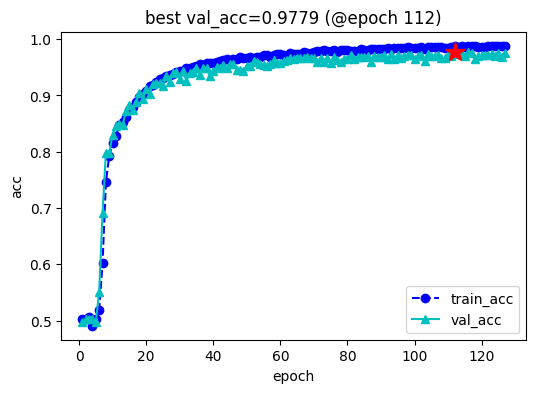

wandb: Currently logged in as: violet6418. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.18.3
wandb: Run data is saved locally in /kaggle/working/wandb/run-20241216_140901-2a1b6a75
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run 2024-12-16 14:09:00
wandb: ‚≠êÔ∏è View project at https://wandb.ai/violet6418/twotransformerbase
wandb: üöÄ View run at https://wandb.ai/violet6418/twotransformerbase/runs/2a1b6a75
wandb:                                                                                
wandb: 
wandb: Run history:
wandb: best_val_acc ‚ñÅ‚ñÅ‚ñÅ‚ñÖ‚ñÜ‚ñá‚ñá‚ñá‚ñá‚ñá‚ñá‚ñá‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà
wandb:        epoch ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÇ‚ñÇ‚ñÇ‚ñÇ‚ñÇ‚ñÇ‚ñÉ‚ñÉ‚ñÉ‚ñÑ‚ñÑ‚ñÑ‚ñÑ‚ñÖ‚ñÖ‚ñÖ‚ñÖ‚ñÖ‚ñÖ‚ñÜ‚ñÜ‚ñÜ‚ñÜ‚ñÜ‚ñÜ‚ñÜ‚ñá‚ñá‚ñá‚ñá‚ñá‚ñà‚ñà‚ñà‚ñà‚ñà
wandb:           lr ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñ

<<<<<< val_acc without improvement in 15 epoch,early stopping >>>>>> 



/tmp/ipykernel_23/2172050041.py:144: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.net.load_state_dict(torch.load(ckpt_path if ckpt_path is not None else self.ckpt_path

In [20]:
dfhistory = model.fit(
      train_data=dl_train,
      val_data=dl_val,
      epochs=config.epochs,
      ckpt_path='checkpoint',
      patience=15,
      monitor='val_acc',
      mode='max',
      callbacks = [wandb_cb]
)